In [1]:
import sys
import copy
import random
import hashlib
import itertools
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import operator
import json
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, average_precision_score
from sklearn.model_selection import validation_curve, learning_curve
from IPython.display import Image
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Data can be downloaded at 

https://drive.google.com/open?id=1H7N3Y7PEm0_442koQeffVfodlOiR0W_o

https://drive.google.com/open?id=1YbI2DFpuR_689OcqTwvRvEgcpu6BXSVt

In [14]:
df = pd.read_csv('sites_markup.csv')

In [ ]:
df.head(3)

## Part 1. Dataset and features description

Dataset was gathered from grocery retail sites.<br>
They all have a similar structure, so it's supposed to be possible to parse this sites not by manual rules, but by crawler which can distinguish between elements in site.<br>
Let's have a look at the sites

In [3]:
Image(url='https://habrastorage.org/webt/xe/ek/vu/xeekvu2aogn6mljs-obb4y7nns0.png', width=700)

In [4]:
Image(url='https://habrastorage.org/webt/vz/vz/u8/vzvzu80khqbtlr3cow9xmj8kgwq.png', width=700)

In [5]:
Image(url='https://habrastorage.org/webt/ng/s3/8w/ngs38wzj4gtl4bnhikmamyjtory.png', width=700)

So they indeed similar.<br>
Let's look at the dataset and features

In [1183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129341 entries, 0 to 129340
Data columns (total 23 columns):
Unnamed: 0               129341 non-null object
childs_tags              129341 non-null object
depth                    129341 non-null int64
element_classes_count    129341 non-null int64
element_classes_words    105612 non-null object
href_seen                129341 non-null bool
img_seen                 129341 non-null bool
inner_elements           129341 non-null int64
is_displayed             129341 non-null bool
is_href                  129341 non-null bool
location                 129341 non-null object
parent_tag               129341 non-null object
screenshot               48761 non-null object
shop                     129341 non-null object
siblings_count           129341 non-null int64
size                     129341 non-null object
tag                      129341 non-null object
text                     0 non-null float64
y                        129341 non-null b

In [1184]:
df.head(2)

,Unnamed: 0,childs_tags,depth,element_classes_count,element_classes_words,href_seen,img_seen,inner_elements,is_displayed,is_href,...,shop,siblings_count,size,tag,text,y,loc_x,loc_y,size_h,size_w
0,ffc674cb-2ee2-41cc-83dd-ba20eb7238ba,,5,1,sendpulse bell path,False,False,0,True,False,...,Европа,0,"{'height': 14.0, 'width': 14.0}",use,NaN,False,96,21,14,14
1,09867f88-1872-4611-9aec-8f09ee0e5941,'use',4,1,sendpulse bell icon,False,False,1,True,False,...,Европа,4,"{'height': 14.0, 'width': 14.0}",svg,NaN,False,96,21,14,14


Features were constructed from common sense and couple papers with similar goal (https://medium.com/contentsquare-engineering-blog/automatic-zone-recognition-in-webpages-68fb2efab822 , https://arxiv.org/pdf/1210.6113.pdf).

<i>childs_tags</i> - tags that nested elements have<br>
<i>depth</i> - depth in HTML markup tree<br>
<i>element_classes_count</i> - how many classes have an element<br>
<i>element_classes_words</i> - element's classes names<br>
<i>href_seen</i> - is href somewhere inside child elements<br>
<i>img_seen</i> - is img somewhere inside child elements<br>
<i>inner_elements</i> - how many nested elements<br>
<i>is_displayed</i> - is_displayed flag from selenium<br>
<i>is_href</i> - is current element href<br>
<i>location</i> - loacation of upper-left corner on page<br>
<i>parent_tag</i> - which tag have element's ancestor<br>
<i>screenshot</i> - path to element's screenshot<br>
<i>shop</i> - shop's name<br>
<i>siblings_count</i> - how many other elements lay on the same layer<br>
<i>size</i> - width and height of element<br>
<i>tag</i> - element's tag<br>
<i>text</i> - text inside the element<br>
<i>y</i> - is it a "product card" our target<br>

Our goal to find "product card" object

In [6]:
Image(url='https://habrastorage.org/webt/if/yo/r2/ifyor2xutwypu-eyqfufqnh2g5o.png', width=900)

As we can see there are many products on the same page. Each product card has many descending elements and specific structure like picture, price, product name, rating, to_cart, etc.

Data was gathered not just by downloading pages to obtain raw html, but with page execution to get element sizes and locations.

When we'll get auto product card recognition, our crawlers will be able to get products from a wide range of sites without explicit rules. It is possible to crawl all sites by hands, but boring and after 20+ sites, it's harder to maintain, because site's structure changes over time.

### Part 1.5 Raw data processing

'childs_tags', 'location', 'parent_tag', 'size' - needs to be corrected. All array elements will be strings with " " separator, and all ints will be separate fields.

In [389]:
df[['loc_x', 'loc_y']] = df['location'].str.replace("'", '"').apply(json.loads).apply(pd.Series)
df[['size_h', 'size_w']] = df['size'].str.replace("'", '"').apply(json.loads).apply(pd.Series)
df.size_h = df.size_h.astype(int)
df.size_w = df.size_w.astype(int)

In [390]:
df['parent_tag'] = df.parent_tag.str.split('_')
df['childs_tags'] = df.childs_tags.apply(lambda x: x.replace('[', '').replace(']','').strip())

Drop some columns

In [392]:
df_clean = df.copy()
df_clean.drop(['location', 'size', 'Unnamed: 0'], axis=1, inplace=True)

## Part 2-3-4. Exploratory data analysis and visual analysis of the features. Patterns, insights, pecularities of data

#### target distribution
First things first. Let's find your target feature distribution.

In [393]:
df_clean['y'].value_counts()

False    126312
True       3029
Name: y, dtype: int64

Only 3k true values, which is 42:1 distribution. No surprise though, we got each element of DOM tree as row start from body.

I've made a screenshot for every element, not for deep learning and image recognition but to ease understanding how an element looks like. (Screenshot for every element it's too many images, so I'll make screenshot over the graph with screenshots =))

How looks target elements:

In [7]:
Image(url='https://habrastorage.org/webt/bz/xy/ds/bzxydsgez9atzsqavsatzgibrlm.png', width=900)

Indeed very simular

#### Overall stats

In [395]:
df_clean.head(1)

,childs_tags,depth,element_classes_count,element_classes_words,href_seen,img_seen,inner_elements,is_displayed,is_href,parent_tag,screenshot,shop,siblings_count,tag,text,y,loc_x,loc_y,size_h,size_w
0,,5,1,sendpulse bell path,False,False,0,True,False,"[body, div, div, svg]",NaN,Европа,0,use,NaN,False,96,21,14,14


In [396]:
continuous_vars = ['depth', 'element_classes_count', 'inner_elements', 'siblings_count', 'loc_x', 'loc_y', 'size_h', 'size_w']

In [397]:
df_clean[continuous_vars].mean()

depth                      12.898532
element_classes_count       1.256964
inner_elements             17.926821
siblings_count              3.607510
loc_x                     403.495860
loc_y                    3264.209663
size_h                     93.453190
size_w                    141.481858
dtype: float64

In [398]:
df_clean[df_clean.y == 1][continuous_vars].mean()

depth                      10.140640
element_classes_count       1.923077
inner_elements             37.172334
siblings_count             14.893364
loc_x                     433.352261
loc_y                    3221.284913
size_h                    354.146253
size_w                    244.189501
dtype: float64

#### depth
At what depth sitting target elements

In [399]:
df_clean[df_clean.y == 1].groupby('shop')['depth'].mean()

shop
Азбука вкуса     8.000000
Европа          10.000000
Комус           10.000000
Метро            9.000000
Окей            13.092545
Перекрёсток     10.000000
Name: depth, dtype: float64

Strange behavior for 'Окей'. Let's investigate.

In [400]:
df_clean[(df_clean.shop ==  'Окей') & (df_clean.y == 1) & (df_clean.depth == 13)].shape

(706, 20)

In [401]:
df_clean[(df_clean.shop ==  'Окей') & (df_clean.y == 1) & (df_clean.depth != 13)].shape

(72, 20)

Almost all product cards from 'Окей' depth == 13, let's look at them

images for df_clean[(df_clean.shop ==  'Окей') & (df_clean.y == 1) & (df_clean.depth == 13)]

In [8]:
Image(url='https://habrastorage.org/webt/vf/uz/rd/vfuzrdfzhrzihvarhglnfk4zdje.png', width=900)

images for df_clean[(df_clean.shop == 'Окей') & (df_clean.y == 1) & (df_clean.depth != 13)]

In [9]:
Image(url='https://habrastorage.org/webt/32/ee/ah/32eeahfoleo-ijciyzz1dvbv8hs.png', width=900)

Looks the same

In [404]:
df_clean[(df_clean.shop ==  'Окей') & (df_clean.y == 1) & (df_clean.depth == 13)].head(1)

,childs_tags,depth,element_classes_count,element_classes_words,href_seen,img_seen,inner_elements,is_displayed,is_href,parent_tag,screenshot,shop,siblings_count,tag,text,y,loc_x,loc_y,size_h,size_w
103350,"'input', 'script', 'span', 'img', 'a', 'label'...",13,2,product ok theme,True,True,31,True,False,"[body, div, div, div, div, div, div, div, div,...",/home/d.perepechin/scr_shot/cf5c43b9-6120-43f9...,Окей,3,div,NaN,True,214,351,304,202


In [405]:
df_clean[(df_clean.shop ==  'Окей') & (df_clean.y == 1) & (df_clean.depth != 13)].head(1)

,childs_tags,depth,element_classes_count,element_classes_words,href_seen,img_seen,inner_elements,is_displayed,is_href,parent_tag,screenshot,shop,siblings_count,tag,text,y,loc_x,loc_y,size_h,size_w
109958,"'input', 'script', 'ul', 'span', 'img', 'a', '...",14,2,product ok theme,True,True,34,True,False,"[body, div, div, div, div, div, div, div, div,...",/home/d.perepechin/scr_shot/d411110f-8f20-4163...,Окей,3,div,NaN,True,214,443,304,202


Same tags and class names, inner_elements vary a little. Everything correct, just depth varies

/home/perepechin/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


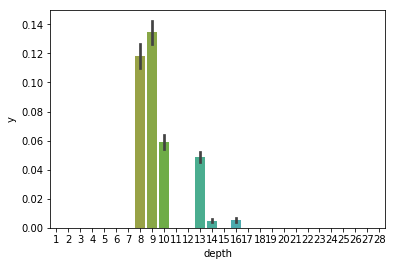

In [406]:
sns.barplot(df_clean.depth, df_clean.y)

Outlayer depth==16

In [407]:
df_clean[(df_clean.y == 1) & (df_clean.depth == 16)].head(1)

,childs_tags,depth,element_classes_count,element_classes_words,href_seen,img_seen,inner_elements,is_displayed,is_href,parent_tag,screenshot,shop,siblings_count,tag,text,y,loc_x,loc_y,size_h,size_w
35167,"'nav', 'img', 'div', 'a', 'span'",16,3,retailrocket item container js product jsrr pr...,True,True,17,True,False,"[body, div, div, section, main, div, ul, div, ...",/home/d.perepechin/scr_shot/7fb326ff-4a62-4b9b...,Перекрёсток,0,div,NaN,True,286,1030,118,222


In [10]:
Image(url='https://habrastorage.org/webt/gm/fz/hi/gmfzhiial3a_fxgj5lfq2oaa-ac.png', width=900)

Most cards in 'Перекрёсток' is 9 depth

In [409]:
df_clean[(df_clean.y == 1) & (df_clean.shop == 'Перекрёсток')].head(1)

,childs_tags,depth,element_classes_count,element_classes_words,href_seen,img_seen,inner_elements,is_displayed,is_href,parent_tag,screenshot,shop,siblings_count,tag,text,y,loc_x,loc_y,size_h,size_w
35062,"'figure', 'svg', 'img', 'li', 'ul', 'figcaptio...",9,2,xf product js product,True,True,52,True,False,"[body, div, div, section, main, div, ul, li]",/home/d.perepechin/scr_shot/8e25c148-996b-4dac...,Перекрёсток,0,div,NaN,True,286,576,395,221


In [11]:
Image(url='https://habrastorage.org/webt/na/us/e4/nause4he1lpfur_l-hvvjug12tk.png', width=900)

Different product cards in one store are in crawler a bag or just store has different cards. In one type there isn't any rating or to_cart

#### Element sizes

In [411]:
df_clean[df_clean.y == 1].groupby('shop')[['size_w', 'size_h']].mean()

,size_w,size_h
shop,,
Азбука вкуса,206.000000,334.000000
Европа,247.000000,420.000000
Комус,714.000000,261.896970
Метро,231.000000,439.923077
Окей,202.000000,304.000000
Перекрёсток,221.142857,355.470588


'Комус' differs a lot

Let's plot all product card's sizes

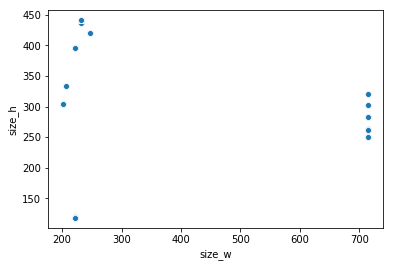

In [412]:
tmp_df = df_clean[(df_clean.y == 1)]
sns.scatterplot(x=tmp_df.size_w, y=tmp_df.size_h)

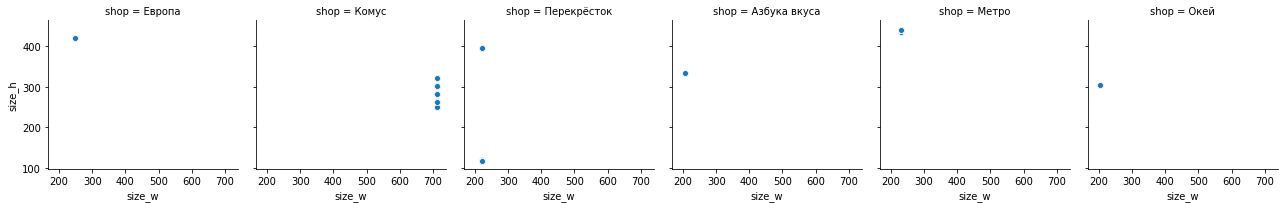

In [413]:
tmp_df = df_clean[(df_clean.y == 1)]
g = sns.FacetGrid(tmp_df, col='shop', hue='y')
g.map(sns.scatterplot, 'size_w', 'size_h')

Firstly we've expected one size for one shop but it is not true. For 'Перекрёсток' and 'Комус' size varies a lot. When we plot all cards size we see they mostly allocated in upper-left corner of plot, with sizes arount 400x220. But what's wrong with 'Комус'? Let's visit the site.

In [12]:
Image(url='https://habrastorage.org/webt/ua/pg/l6/uapgl6ei_c1knebnz9ls8rvlbdq.png', width=900)

The structure is different. In most shops, we see tile-layout, but here list-layout. For the sake of simplicity, I'll exclude 'Комус' from out dataframe.

In [415]:
print(f'unique shops - {df_clean.shop.unique()}')
df_clean = df_clean[df_clean.shop != 'Комус']
print(f'unique shops after drop - {df_clean.shop.unique()}')

unique shops - ['Европа' 'Комус' 'Перекрёсток' 'Азбука вкуса' 'Метро' 'Окей']
unique shops after drop - ['Европа' 'Перекрёсток' 'Азбука вкуса' 'Метро' 'Окей']


Now let's see how target sizes corresponds with all others

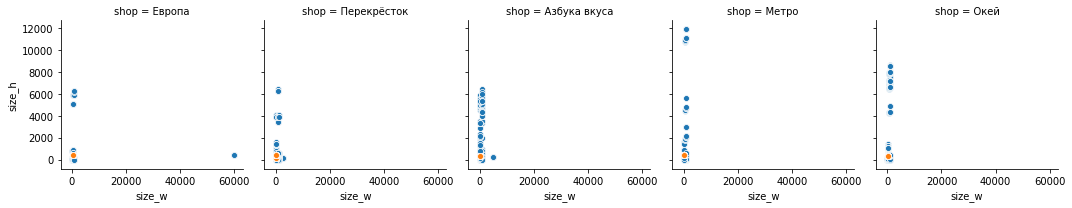

In [416]:
tmp_df = df_clean
g = sns.FacetGrid(tmp_df, col='shop', hue='y')
g.map(sns.scatterplot, 'size_w', 'size_h')

Outliers disturb the picture

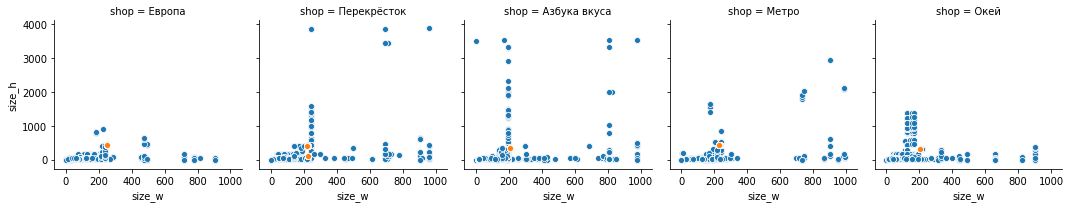

In [417]:
tmp_df = df_clean[(df_clean.size_w < 1000) & (df_clean.size_h < 4000)]
g = sns.FacetGrid(tmp_df, col='shop', hue='y')
g.map(sns.scatterplot, 'size_w', 'size_h')

Zoom closer

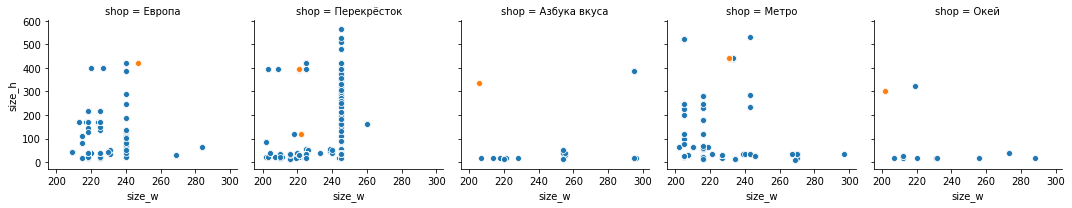

In [418]:
tmp_df = df_clean[(df_clean.size_w > 200) &(df_clean.size_w < 300) & (df_clean.size_h < 600)]
g = sns.FacetGrid(tmp_df, col='shop', hue='y')
g.map(sns.scatterplot, 'size_w', 'size_h')

Looks like a great feature with a strong correlation between shops and refinement from other DOM elements

#### location

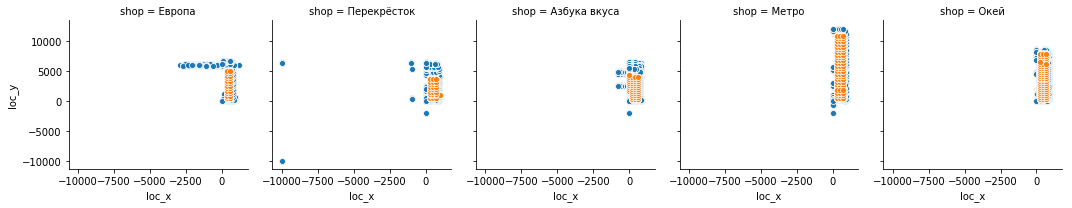

In [419]:
tmp_df = df_clean
g = sns.FacetGrid(tmp_df, col='shop', hue='y')
g.map(sns.scatterplot, 'loc_x', 'loc_y' )

Location at negative positions?!

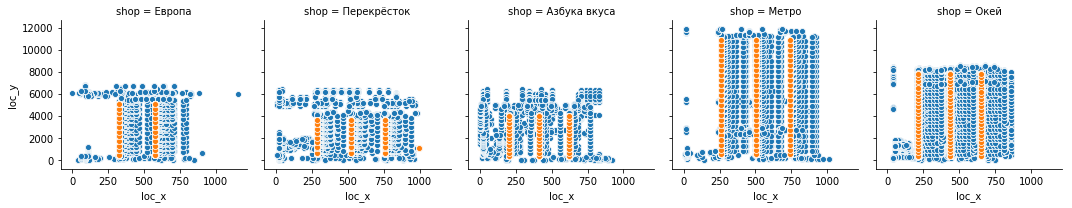

In [420]:
tmp_df = df_clean[(df_clean.loc_x > 0) & (df_clean.loc_y > 0)]
g = sns.FacetGrid(tmp_df, col='shop', hue='y')
g.map(sns.scatterplot, 'loc_x', 'loc_y' )

Positions as we expected. Strong tabular structure, maybe we can make a new feature from this fact.

Outliers in 'Перекрёсток', lets see

In [421]:
df_clean[(df_clean.loc_x > 900) & (df_clean.y == 1) & (df_clean.shop == 'Перекрёсток')].head(2)

,childs_tags,depth,element_classes_count,element_classes_words,href_seen,img_seen,inner_elements,is_displayed,is_href,parent_tag,screenshot,shop,siblings_count,tag,text,y,loc_x,loc_y,size_h,size_w
35204,'div',16,3,retailrocket item container js product jsrr pr...,False,False,5,True,False,"[body, div, div, section, main, div, ul, div, ...",/home/d.perepechin/scr_shot/062c4b80-50b3-4ca4...,Перекрёсток,0,div,NaN,True,994,1030,118,222
37033,'div',16,3,retailrocket item container js product jsrr pr...,False,False,5,True,False,"[body, div, div, section, main, div, ul, div, ...",/home/d.perepechin/scr_shot/1495cc5b-41e0-4109...,Перекрёсток,0,div,NaN,True,994,1030,118,222


In [13]:
Image(url='https://habrastorage.org/webt/hz/oe/e5/hzoee5akuroyw3hedikww33qg1k.png', width=900)

?????

Don't know what it is. Better drop.

In [423]:
print(f'rows in - {df_clean.shape[0]}')
df_clean = df_clean.drop(df_clean[(df_clean.loc_x > 900) & (df_clean.y == 1) & (df_clean.shop == 'Перекрёсток')].index)
print(f'rows after drop - {df_clean.shape[0]}')

rows in - 114915
rows after drop - 114898


#### is_displayed

In [424]:
df_clean.groupby('is_displayed')['y'].sum()

is_displayed
True    2847.0
Name: y, dtype: float64

All rows is_displayed = true - redundant feature

In [425]:
df_clean.drop(labels='is_displayed', axis=1, inplace=True)

#### inner_elements

In [426]:
df_clean['inner_elements'].mean()

18.29651516997685

In [427]:
df_clean[df_clean.y == 1]['inner_elements'].mean()

34.82226905514577

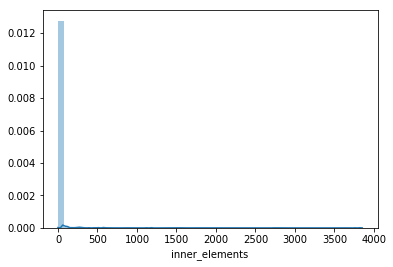

In [428]:
sns.distplot(df_clean.inner_elements);

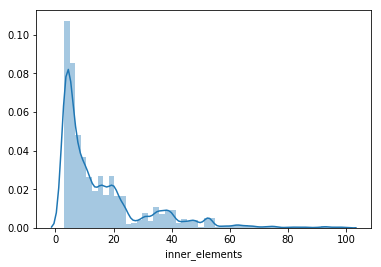

In [429]:
sns.distplot(df_clean[(df_clean.inner_elements > 2) & (df_clean.inner_elements < 100) ].inner_elements);

Maybe the feature was poorly designed. For each element, we count inner_element till the leaves, so in "body" it will be all other element treated as inner. 

#### tag

In [430]:
df_clean['tag'].unique()

array(['use', 'svg', 'div', 'button', 'b', 'span', 'a', 'li', 'ul', 'img',
       'input', 'form', 'article', 'i', 'h3', 'p', 'title', 'circle',
       'label', 'body', 'hr', 'dt', 'dd', 'dl', 'nav', 'aside', 'header',
       'h1', 'section', 'figure', 'path', 'main', 'footer', 'iframe',
       'sup', 'h2', 'nobr', 'td', 'tr', 'tbody', 'table', 'h6',
       'ym-measure', 'legend', 'fieldset'], dtype=object)

In [431]:
df_clean[df_clean.y == 1]['tag'].unique()

array(['div'], dtype=object)

Our cards only 'div' elements. How many other div's ?

In [432]:
df_clean[df_clean.tag == 'div'].groupby('y').size()

y
False    41295
True      2847
dtype: int64

In [433]:
df_clean.groupby('tag').size()

tag
a             14353
article         436
aside            70
b              1106
body             74
button         1736
circle           17
dd               68
div           44142
dl               68
dt               68
fieldset         52
figure          476
footer           35
form             96
h1               59
h2                6
h3               15
h6               48
header          104
hr               34
i               492
iframe           68
img            3418
input          1325
label          1518
legend           52
li             8682
main             35
nav             197
nobr             84
p               629
path             92
section         194
span          23828
sup             914
svg            4053
table            59
tbody            59
td              160
title            21
tr               70
ul             1934
use            3939
ym-measure       12
dtype: int64

Still, there are a lot div's that isn't our target, but feature is good.

#### siblings_count

In [434]:
df_clean[df_clean.y == 1]['siblings_count'].unique()

array([23,  0, 41, 39, 17,  1,  3])

In [435]:
df_clean[df_clean.y == 1].groupby('shop')['siblings_count'].agg(['unique'])

,unique
shop,
Азбука вкуса,"[41, 39, 17]"
Европа,[23]
Метро,[1]
Окей,[3]
Перекрёсток,[0]


The feature was designed to show how many "siblings" around an element. Product cards supposed to lay in lists so they are at the same level. If it is 30 products per page siblings_count supposed to be 29. But something is wrong. Let's check out original sites. 'Перекрёсток' for example.

In [14]:
Image(url='https://habrastorage.org/webt/it/gk/7t/itgk7tfxsnyzsnda-zmiejtnu5o.png', width=900)

In [15]:
Image(url='https://habrastorage.org/webt/em/i-/v9/emi-v9grsih0_i5rhbpnmhuloec.png', width=900)

In [16]:
Image(url='https://habrastorage.org/webt/vr/in/0y/vrin0yedugz7xudlg7bpmhm8oi0.png', width=900)

We see there is a list 'ul' that contains 'li' that contains 'div'. So element 'li' would behave as we would expect - right siblings_count, but 'div' inside 'li' siblings_count == 1. It's supposed to be reframed or possibly fruitful feature is dead.

#### is_href

In [439]:
df_clean[df_clean.y == 1]['is_href'].mean()

0.0

In [440]:
df_clean[df_clean.y == 0]['is_href'].mean()

0.1276026095260194

Our product cards not clickable

#### element_classes_words

In [441]:
for shop, tmp_df in df_clean[df_clean.y == 1].groupby('shop'):
    print(shop)
    print(tmp_df['element_classes_words'].unique())


Азбука вкуса
['b grid  item']
Европа
['product item  product vertical  mobile ect ect gram'
 'product item  product vertical  mobile']
Метро
['catalog i w']
Окей
['product ok theme']
Перекрёсток
['xf product js product  '
 'retailrocket item container js product jsrr product']


It's css class naming that totally depends on developers. But in some cases, we see names like "product", "item", that could be helpful. There isn't enough data to say for sure.

#### parent_tag

In [442]:
for shop, tmp_df in df_clean[df_clean.y == 1].groupby('shop'):
    print(shop)
    print(tmp_df['parent_tag'].head(1))
               

Азбука вкуса
66783    [body, div, main, div, div, div, div]
Name: parent_tag, dtype: object
Европа
195    [body, div, div, div, div, div, div, div, div]
Name: parent_tag, dtype: object
Метро
87173    [body, div, div, div, div, div, div, div]
Name: parent_tag, dtype: object
Окей
103350    [body, div, div, div, div, div, div, div, div,...
Name: parent_tag, dtype: object
Перекрёсток
35062    [body, div, div, section, main, div, ul, li]
Name: parent_tag, dtype: object


#### childs_tags

In [443]:
for shop, tmp_df in df_clean[df_clean.y == 1].groupby('shop'):
    print(shop)
    print(tmp_df['childs_tags'].head(1))
               

Азбука вкуса
66783    'img', 'div', 'sup', 'a', 'span', 'b', 'button'
Name: childs_tags, dtype: object
Европа
195    'article', 'span', 'a', 'input', 'button', 'di...
Name: childs_tags, dtype: object
Метро
87173    'span', 'a', 'div', 'b', 'img'
Name: childs_tags, dtype: object
Окей
103350    'input', 'script', 'span', 'img', 'a', 'label'...
Name: childs_tags, dtype: object
Перекрёсток
35062    'figure', 'svg', 'img', 'li', 'ul', 'figcaptio...
Name: childs_tags, dtype: object


It's simple and simular parent-child markup for all shops except 'Перекрёсток'. But we should be ready for this. In this state we couldn't use this features.

#### text

In [444]:
df_clean[df_clean.text.notna()]

,childs_tags,depth,element_classes_count,element_classes_words,href_seen,img_seen,inner_elements,is_href,parent_tag,screenshot,shop,siblings_count,tag,text,y,loc_x,loc_y,size_h,size_w


Feature 'text' is empty. Obviously due to a bag in the crawler. Feature possibly very important. If we know that near inside words like "cheese", "milk", "meat" - definitely it's a grocery. The model will be not just single-language but singe-domain-specific. When we'll crawl construction materials shop there won't be any "cheese". I like to try build a model robust to domain and language variations. I want to parse shops that's all.

#### img_seen

In [445]:
df_clean[df_clean.y == 1]['img_seen'].mean()

1.0

In [446]:
df_clean[df_clean.y == 0]['img_seen'].mean()

0.14877154153019606

Yes, there is an image inside each product card

#### href_seen

In [447]:
df_clean[df_clean.y == 1]['href_seen'].mean()

1.0

In [448]:
df_clean[df_clean.y == 0]['href_seen'].mean()

0.3531963123934637

And a href inside each product card

## Part 5. Feature engineering and description

Some feature processing was done above we obtain size and loc

In [449]:
df_clean.head(3)

,childs_tags,depth,element_classes_count,element_classes_words,href_seen,img_seen,inner_elements,is_href,parent_tag,screenshot,shop,siblings_count,tag,text,y,loc_x,loc_y,size_h,size_w
0,,5,1,sendpulse bell path,False,False,0,False,"[body, div, div, svg]",NaN,Европа,0,use,NaN,False,96,21,14,14
1,'use',4,1,sendpulse bell icon,False,False,1,False,"[body, div, div]",NaN,Европа,4,svg,NaN,False,96,21,14,14
2,,4,2,sendpulse prompt info sendpulse prompt message...,False,False,0,False,"[body, div, div]",NaN,Европа,4,div,NaN,False,115,16,22,495


Some parts of FE was done on crawler's phase. Features like href_seen and img_seen mean that some of the child elements have img or href inside, but it's out of bounds. Maybe 2-3-4 descending elements should mean that image near, but not all way down.

Main limitation now that in dataset not saved relations between elements. Firstly I got row's id, but no reference that this id is a parent somewhere. Fixing this on next iteration will allow me to create more dependent features.

But even now we can recreate parent's tag order.

In [450]:
df_clean['parent_1'] = df_clean.parent_tag.apply(lambda x: x[-1])
df_clean['parent_2'] = df_clean.parent_tag.apply(lambda x: x[-2] if len(x) > 1 else '')
df_clean['parent_3'] = df_clean.parent_tag.apply(lambda x: x[-3] if len(x) > 2 else '')

In [490]:
df_clean[df_clean.y == 1].sample(2)

,childs_tags,depth,element_classes_count,element_classes_words,href_seen,img_seen,inner_elements,is_href,parent_tag,screenshot,...,tag,text,y,loc_x,loc_y,size_h,size_w,parent_1,parent_2,parent_3
70697,"'img', 'div', 'sup', 'a', 'span', 'b', 'button'",8,1,b grid item,True,True,21,False,"[body, div, main, div, div, div, div]",/home/d.perepechin/scr_shot/1a21392b-141d-4036...,...,div,NaN,True,412,2995,334,206,div,div,div
104237,"'input', 'script', 'span', 'img', 'a', 'label'...",13,2,product ok theme,True,True,31,False,"[body, div, div, div, div, div, div, div, div,...",/home/d.perepechin/scr_shot/cd8adb81-4383-44ae...,...,div,NaN,True,653,3915,304,202,li,ul,div


With parent and id reference I'll be able to add features like <b>ankle_count</b> (parent's siblings =)), <b>parent_size</b>, <b>parent_location</b>, <b>parent_class</b> etc. But now it's not feasible.

Another good possible feature might be a number of "similar" objects on the page. Similar in terms of css class names or in terms of size and location. But I don't have any possibility to do it now since there is no "url" feature so I can't implement it now.

You might wonder, why I haven't fixed these properties of the crawler. A quick pipeline is a crucial property of ML system building. While I don't have metric's results I won't be stuck to infinite improve of the previous steps.

We can ues element_classes_words, but since it close to work with vocabulary, we should do it only after validation split.

## Part 6. Metrics selection

In [488]:
df_clean.y.value_counts()

False    112051
True       2847
Name: y, dtype: int64

Firstly I want point out that loss function and metric score may be different. 

#### metric

We have a classification problem and unbalanced class, so usage of the simplest possible metrics accuracy is not good. False positive and False negative cases don't have any priority. When new crawler will miss correct product cards some information will be lost. When crawler will wrongly identify product card in a database will be stored garbage information. Actually on top of this product card identifier will be build product name, product price, product image, product category identifiers. So garbage info will cause problems along the line. Now I think FP and FN have the same weight.

So we probably want to check few metrics to understand our model's behavior. It'll be ROC AUC, PR AUC, F1 score and confusion matrix. It's impossible to get better at all metrics so will pick exactly one later.

I like PR AUC the most. PR is short for <b>Precision Recall</b>. They somehow similar to ROC AUC.

A ROC curve is plotting True Positive Rate (TPR) against False Positive Rate (FPR).

A PR curve is plotting Precision against Recall.

PR does not account for true negatives (as TN is not a component of either Precision or Recall). So if there are many more negatives than positives (a characteristic of class imbalance problem), we should use PR.

http://www.chioka.in/differences-between-roc-auc-and-pr-auc/

#### loss

Logarithmic loss default option but it may be wrong. I'll remind you.

In [17]:
Image(url='https://habrastorage.org/webt/p7/u6/cp/p7u6cppqgqauzlsenfrsfdymygw.png', width=900)

This is a <b>different</b> elements, one of them marked as True another as False. It's "div" inside "li", almost exact shape, almost exact position. Would it be fair to penalize our model guessing it both product cards?

## Part 7. Model selection

We don't have tons of features and tons of data so it is firm NO to neural nets and boosting. Data is rather simple so the model should match. From previous analyze we saw that parent tag with combination to siblings_count can mean a lot (if our target "div" inside "li" siblings mean nothing if div inside div siblings - correlate to target), this complicated feature interactions can't be captured by the linear model. Random forests supposed to work like a charm (I'll give a try to linear model either).

## Part 8. Data preprocessing

In [493]:
df_clean.head(1)

,childs_tags,depth,element_classes_count,element_classes_words,href_seen,img_seen,inner_elements,is_href,parent_tag,screenshot,...,tag,text,y,loc_x,loc_y,size_h,size_w,parent_1,parent_2,parent_3
0,,5,1,sendpulse bell path,False,False,0,False,"[body, div, div, svg]",NaN,...,use,NaN,False,96,21,14,14,svg,div,div


In [492]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114898 entries, 0 to 129340
Data columns (total 22 columns):
childs_tags              114898 non-null object
depth                    114898 non-null int64
element_classes_count    114898 non-null int64
element_classes_words    93176 non-null object
href_seen                114898 non-null bool
img_seen                 114898 non-null bool
inner_elements           114898 non-null int64
is_href                  114898 non-null bool
parent_tag               114898 non-null object
screenshot               46091 non-null object
shop                     114898 non-null object
siblings_count           114898 non-null int64
tag                      114898 non-null object
text                     0 non-null float64
y                        114898 non-null bool
loc_x                    114898 non-null int64
loc_y                    114898 non-null int64
size_h                   114898 non-null int64
size_w                   114898 non-null int64

"childs_tags" can't be used. "text" always NaN. "screenshot" used only for visual validation. "shop" can't be used as metric as we are targeting to new shops (but I need it for a while). "element_classes_words" will use a little bit later. All other fields were dropped earlier. I'm holding y in X for a while bear with me.

In [1006]:
features_to_train = ['depth', 'element_classes_count', 'href_seen', 'img_seen',
              'inner_elements', 'is_href', 'siblings_count', 'tag', 'loc_x',
             'loc_y', 'size_h', 'size_w', 'parent_1','parent_2', 'parent_3', 'shop', 'y']
categorical_columns = ['tag', 'parent_1','parent_2','parent_3']
continuous_columns = ['depth', 'element_classes_count','inner_elements','siblings_count',
                      'loc_x','loc_y', 'size_h', 'size_w']

In [915]:
X = df_clean[features_to_train]
y = df_clean.y

For RF we don't have to make OHE, so I'll just convert str to int.

In [918]:
possible_tags_categories = X['tag'].astype('category')
possible_parent_categories = X['parent_1'].astype('category')
all_tags = list(possible_tags_categories.cat.categories) + list(possible_parent_categories.cat.categories)
num_to_category = {i:cat for i, cat in enumerate(all_tags)}
category_to_num = {cat:i for i, cat in num_to_category.items()}

In [919]:
X['tag'] = X['tag'].apply(lambda x: category_to_num[x])
X['parent_1'] = X['parent_1'].apply(lambda x: category_to_num[x] if x else -1)
X['parent_2'] = X['parent_2'].apply(lambda x: category_to_num[x] if x else -1)
X['parent_3'] = X['parent_3'].apply(lambda x: category_to_num[x] if x else -1)

In [920]:
X.head(1)

,depth,element_classes_count,href_seen,img_seen,inner_elements,is_href,siblings_count,tag,loc_x,loc_y,size_h,size_w,parent_1,parent_2,parent_3,shop,y
0,5,1,False,False,0,False,0,43,96,21,14,14,67,52,52,Европа,False


#### Preprocessing for linear model

In [800]:
X_linear = df_clean[['depth', 'element_classes_count', 'href_seen', 'img_seen',
              'inner_elements', 'is_href', 'siblings_count', 'tag', 'loc_x',
             'loc_y', 'size_h', 'size_w', 'parent_1','parent_2', 'parent_3', 'shop', 'y']]
y = df_clean.y

For linear models, we need scaled numeric features and OHE for categorical

In [807]:
X_linear = pd.get_dummies(X_linear, columns=categorical_columns, drop_first=True,
                            prefix=categorical_columns, sparse=False)

In [810]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_linear[continuous_columns] = scaler.fit_transform(X_linear[continuous_columns])

In [812]:
X_linear.head(2)

,depth,element_classes_count,href_seen,img_seen,inner_elements,is_href,siblings_count,loc_x,loc_y,size_h,...,parent_3_li,parent_3_main,parent_3_nav,parent_3_section,parent_3_span,parent_3_table,parent_3_tbody,parent_3_td,parent_3_tr,parent_3_ul
0,-2.068695,-0.227842,False,False,-0.117237,False,-0.328032,-0.727281,-1.322974,-0.180915,...,0,0,0,0,0,0,0,0,0,0
1,-2.332740,-0.227842,False,False,-0.110830,False,0.020122,-0.727281,-1.322974,-0.180915,...,0,0,0,0,0,0,0,0,0,0


Now we have data for linear and rf models

## Part 9. Cross-validation and adjustment of model hyperparameters

In [833]:
def print_scores(y_true, preds, verbose=True):
    f1 = f1_score(y_true, preds)
    roc_auc = roc_auc_score(y_true, preds)
    pr_auc = average_precision_score(y_true, preds)
    if verbose:
        print(f'F1 score is {f1}')
        print(f'ROC_AUC score is {roc_auc}')
        print(f'PR_AUC is {pr_auc}')
        print(f'confusion_matrix \n {confusion_matrix(y_true, preds)}')
    return f1, roc_auc, pr_auc

Usual approach for data split supposed to look like this. We won't forget to drop target variable

In [821]:
X_train,X_val,y_train,y_val = train_test_split(X.drop(['shop', 'y'],axis=1),y, random_state=42)
X_train.shape,X_val.shape,y_train.shape,y_val.shape

((86173, 15), (28725, 15), (86173,), (28725,))

#### Random forest

In [823]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
preds = rf.predict(X_val)
print_scores(y_val, preds);

F1 score is 1.0
ROC_AUC score is 1.0
PR_AUC is 1.0
confusion_matrix 
 [[28045     0]
 [    0   680]]


OMG we are perfect! Actually not. The only way to make reasonable test - separate all examples for one shop. It doesn't matter how many examples we leave out 5% or 50%. We should learn on shops we have and use it in the wild on other shops we haven't crawled before.

So better to do it.

I'll implement cross-val score by hands

In [658]:
diff_shops_df = [ (shop_name, shop_df) for shop_name, shop_df in X.groupby('shop')]
for shop_name, shop_df in diff_shops_df:
    y_cross_val = shop_df.y
    X_cross_val = shop_df.drop(['y', 'shop'],axis=1) # validation only 1 shop
    X_cross_train = X.drop(X_cross_val.index) # train all X without 1 shop
    y_cross_train = X_cross_train.y
    X_cross_train = X_cross_train.drop(['shop', 'y'],axis=1)
    
    rf = RandomForestClassifier(n_estimators=100,max_features='sqrt', criterion='entropy', min_samples_leaf=5,n_jobs=-1,)
    rf.fit(X_cross_train,y_cross_train)
    preds = rf.predict(X_cross_val)
    print(f'**********shop - {shop_name}*************')
    print(f'Train shape {X_cross_train.shape}')
    print(f'Val shape {X_cross_val.shape}')
    print_scores(y_cross_val, preds);

**********shop - Азбука вкуса*************
Train shape (94359, 15)
Val shape (20539, 15)
F1 score is 0.0
ROC_AUC score is 0.5
PR_AUC is 0.035542139344661376
confusion_matrix 
 [[19809     0]
 [  730     0]]
**********shop - Европа*************
Train shape (94618, 15)
Val shape (20280, 15)
F1 score is 0.0
ROC_AUC score is 0.49126506024096384
PR_AUC is 0.01775147928994083
confusion_matrix 
 [[19572   348]
 [  360     0]]
**********shop - Метро*************
Train shape (99217, 15)
Val shape (15681, 15)
F1 score is 0.0
ROC_AUC score is 0.4948222412769606
PR_AUC is 0.03316115043683439
confusion_matrix 
 [[15004   157]
 [  520     0]]
**********shop - Окей*************
Train shape (88191, 15)
Val shape (26707, 15)
F1 score is 0.0
ROC_AUC score is 0.5
PR_AUC is 0.02913093945407571
confusion_matrix 
 [[25929     0]
 [  778     0]]
**********shop - Перекрёсток*************
Train shape (83207, 15)
Val shape (31691, 15)
F1 score is 0.0
ROC_AUC score is 0.5
PR_AUC is 0.014483607333312297
confusion

Results are disaster.

Almost every time we got 100% false predictions, couple time FP, let's watch them

In [659]:
X_train_analize = X.drop(X[X.shop == 'Европа'].index)
X_val_analize = X[X.shop == 'Европа']
y_train_analize = X_train_analize.y
y_val_analize = X_val_analize.y
X_train_analize.drop(['shop','y'],axis=1, inplace=True)
X_val_analize.drop(['shop','y'],axis=1, inplace=True)

rf = RandomForestClassifier(n_estimators=100,max_features='sqrt', criterion='entropy', min_samples_leaf=5,n_jobs=-1,)
rf.fit(X_train_analize,y_train_analize)
preds = rf.predict(X_val_analize)
print_scores(y_val_analize, preds);

F1 score is 0.0
ROC_AUC score is 0.4907379518072289
PR_AUC is 0.01775147928994083
confusion_matrix 
 [[19551   369]
 [  360     0]]


In [644]:
X_val_analize[y_val_analize == True].head(5)

,depth,element_classes_count,href_seen,img_seen,inner_elements,is_href,siblings_count,tag,loc_x,loc_y,size_h,size_w,parent_1,parent_2,parent_3
195,10,5,True,True,45,False,23,52,328,437,420,247,52,52,52
229,10,5,True,True,45,False,23,52,575,437,420,247,52,52,52
263,10,5,True,True,45,False,23,52,328,858,420,247,52,52,52
297,10,5,True,True,45,False,23,52,575,858,420,247,52,52,52
331,10,5,True,True,45,False,23,52,328,1278,420,247,52,52,52


In [645]:
X_val_analize[preds == True].head(5)

,depth,element_classes_count,href_seen,img_seen,inner_elements,is_href,siblings_count,tag,loc_x,loc_y,size_h,size_w,parent_1,parent_2,parent_3
194,11,1,True,True,44,False,0,46,338,437,400,227,52,52,52
228,11,1,True,True,44,False,0,46,585,437,400,227,52,52,52
262,11,1,True,True,44,False,0,46,338,858,400,227,52,52,52
296,11,1,True,True,44,False,0,46,585,858,400,227,52,52,52
330,11,1,True,True,44,False,0,46,338,1278,400,227,52,52,52


Check indexes for validation and true_y. Suspiciously, they differ at 1.

In [654]:
df_clean[df_clean.index.isin(X_val_analize[preds == True].index)].head(3)

,childs_tags,depth,element_classes_count,element_classes_words,href_seen,img_seen,inner_elements,is_href,parent_tag,screenshot,...,tag,text,y,loc_x,loc_y,size_h,size_w,parent_1,parent_2,parent_3
194,"'span', 'a', 'input', 'button', 'div', 'img'",11,1,fly out,True,True,44,False,"[body, div, div, div, div, div, div, div, div,...",/home/d.perepechin/scr_shot/06b9341c-69b1-41d9...,...,article,NaN,False,338,437,400,227,div,div,div
228,"'span', 'a', 'input', 'button', 'div', 'img'",11,1,fly out,True,True,44,False,"[body, div, div, div, div, div, div, div, div,...",/home/d.perepechin/scr_shot/0ca8b11e-eabf-4ea6...,...,article,NaN,False,585,437,400,227,div,div,div
262,"'span', 'a', 'input', 'button', 'div', 'img'",11,1,fly out,True,True,44,False,"[body, div, div, div, div, div, div, div, div,...",/home/d.perepechin/scr_shot/8f4c4356-248f-4d57...,...,article,NaN,False,338,858,400,227,div,div,div


In [18]:
# screen for df_clean[df_clean.index.isin(X_val_analize[preds == True].index)].screenshot
Image(url='https://habrastorage.org/webt/x1/no/c5/x1noc54flobtv8lyf3ip66te05k.png', width=900)

Yep, correct elements, but some confusions with nested div-div-li-article arose. As humans, we see classification correct, but machine thinks differently.

And by confusion matrix we can see number of FN == 360 and FP == 369. So maybe 9 elements were really misclassified. I think because we treating as correct product card only those in the main catalog, but it's always some promos on the sides.

Let's check 'Метро' either.

In [674]:
X_train_analize = X.drop(X[X.shop == 'Метро'].index)
X_val_analize = X[X.shop == 'Метро']
y_train_analize = X_train_analize.y
y_val_analize = X_val_analize.y
X_train_analize.drop(['shop','y'],axis=1, inplace=True)
X_val_analize.drop(['shop','y'],axis=1, inplace=True)

rf = RandomForestClassifier(n_estimators=100,max_features='sqrt', criterion='entropy', min_samples_leaf=5,n_jobs=-1,)
rf.fit(X_train_analize,y_train_analize)
preds = rf.predict(X_val_analize)
print_scores(y_val_analize, preds);

F1 score is 0.0
ROC_AUC score is 0.4931073148209221
PR_AUC is 0.03316115043683439
confusion_matrix 
 [[14952   209]
 [  520     0]]


In [661]:
X_val_analize[y_val_analize == True].head(5)

,depth,element_classes_count,href_seen,img_seen,inner_elements,is_href,siblings_count,tag,loc_x,loc_y,size_h,size_w,parent_1,parent_2,parent_3
87173,9,1,True,True,38,False,1,52,260,478,441,231,52,52,52
87195,9,1,True,True,27,False,1,52,501,478,441,231,52,52,52
87220,9,1,True,True,38,False,1,52,742,478,441,231,52,52,52
87245,9,1,True,True,38,False,1,52,260,929,441,231,52,52,52
87267,9,1,True,True,27,False,1,52,501,929,441,231,52,52,52


In [662]:
X_val_analize[preds == True].head(5)

,depth,element_classes_count,href_seen,img_seen,inner_elements,is_href,siblings_count,tag,loc_x,loc_y,size_h,size_w,parent_1,parent_2,parent_3
87772,8,2,True,True,40,False,71,52,259,477,443,233,52,52,52
87794,8,2,True,True,29,False,71,52,500,477,443,233,52,52,52
87816,8,2,True,True,29,False,71,52,741,477,443,233,52,52,52
87841,8,2,True,True,40,False,71,52,259,928,443,233,52,52,52
87866,8,2,True,True,32,False,71,52,500,928,443,233,52,52,52


In [663]:
df_clean[df_clean.index.isin(X_val_analize[preds == True].index)].head(3)

,childs_tags,depth,element_classes_count,element_classes_words,href_seen,img_seen,inner_elements,is_href,parent_tag,screenshot,...,tag,text,y,loc_x,loc_y,size_h,size_w,parent_1,parent_2,parent_3
87772,"'div', 'a', 'img', 'b', 'span'",8,2,catalog i\n\t\t\t price rules\t,True,True,40,False,"[body, div, div, div, div, div, div]",/home/d.perepechin/scr_shot/eca0c259-fce1-4273...,...,div,NaN,False,259,477,443,233,div,div,div
87794,"'div', 'a', 'img', 'span'",8,2,catalog i\n\t\t need cost redef\t\t,True,True,29,False,"[body, div, div, div, div, div, div]",/home/d.perepechin/scr_shot/47d5d630-a600-465e...,...,div,NaN,False,500,477,443,233,div,div,div
87816,"'div', 'a', 'img', 'span'",8,2,catalog i\n\t\t need cost redef\t\t,True,True,29,False,"[body, div, div, div, div, div, div]",/home/d.perepechin/scr_shot/c6a842ab-569d-4f14...,...,div,NaN,False,741,477,443,233,div,div,div


In [19]:
# screen for df_clean[df_clean.index.isin(X_val_analize[preds == True].index)].screenshot
Image(url='https://habrastorage.org/webt/to/4g/uw/to4guwglcb6epg6pf12bjehd69k.png', width=900)

Same story with 'Метро' correct cards, but wrong elements.

However confusion matrix is worser FN == 520 FP == 209, We are missing a lot.

All other shops doing much worse. All predictions for them - False. It's harder to analyze.

In [679]:
X_train_analize = X.drop(X[X.shop == 'Окей'].index)
X_val_analize = X[X.shop == 'Окей']
y_train_analize = X_train_analize.y
y_val_analize = X_val_analize.y
X_train_analize.drop(['shop','y'],axis=1, inplace=True)
X_val_analize.drop(['shop','y'],axis=1, inplace=True)

rf = RandomForestClassifier(n_estimators=100,max_features='sqrt', criterion='entropy', min_samples_leaf=5,n_jobs=-1,)
rf.fit(X_train_analize,y_train_analize)
preds = rf.predict(X_val_analize)
print_scores(y_val_analize, preds);

F1 score is 0.0
ROC_AUC score is 0.5
PR_AUC is 0.02913093945407571
confusion_matrix 
 [[25929     0]
 [  778     0]]


In [686]:
# Extra module pip install treeinterpreter
from treeinterpreter import treeinterpreter as ti

In [791]:
test_example = X_val_analize[y_val_analize == False].sample(1)
print(rf.predict_proba(test_example))

[[1. 0.]]


In [792]:
test_example = X_val_analize[y_val_analize == True].sample(1)
print(rf.predict_proba(test_example))

[[0.87 0.13]]


In probabilities, we see the difference between the correct class and incorrect. Tree picks a most probable class, but maybe we can leverage another approach

In [793]:
prediction, bias, contributions = ti.predict(rf, test_example)
prediction, bias

(array([[0.87, 0.13]]), array([[0.97661689, 0.02338311]]))

Forest is highly biased onto False assumptions, let's pick elements with the probability being true not > 0.5, but >bias.

In [794]:
preds_proba = rf.predict_proba(X_val_analize)
true_class_probs = preds_proba[:,1]
(true_class_probs > 0.023).sum()

1890

1890 elements. Too many for our shop, but who cares. Let's analyze further.

In [20]:
# screen for df_clean[df_clean.index.isin((true_class_probs > 0.023).index)].screenshot
Image(url='https://habrastorage.org/webt/yk/sk/t5/ykskt5lziqsgazssbkkk8vgm3w8.png', width=900)

In [21]:
# screen for df_clean[df_clean.index.isin((true_class_probs > 0.023).index)].screenshot
Image(url='https://habrastorage.org/webt/yd/aj/kz/ydajkzlfdllxmdmus-v5vunfwcm.png', width=900)

It's 778 true elements for 'Окей' while we predicting 1890 above the bias. Look closer to the pics of correct elements some of them have ~330 pix height, some ~300. It's our favorite problem div in div. I assume there are 2 predictions for every correct element. So we have 778*2 = 1556 "correct" predictions and 1890-1556=334 FP. Of course, I can tweak confidence level as I want to, but the bias term gives me a clear sign of shop's distribution.

Let's adopt predictions above the bias level.

In [938]:
diff_shops_df = [ (shop_name, shop_df) for shop_name, shop_df in X.groupby('shop')]
f1s = list()
rocs = list()
prs = list()
for shop_name, shop_df in diff_shops_df:
    y_cross_val = shop_df.y
    X_cross_val = shop_df.drop(['y', 'shop'],axis=1) # validation only 1 shop
    X_cross_train = X.drop(X_cross_val.index) # train all X without 1 shop
    y_cross_train = X_cross_train.y
    X_cross_train = X_cross_train.drop(['shop', 'y'],axis=1)
    
    rf = RandomForestClassifier(n_estimators=100,max_features='sqrt', criterion='entropy', min_samples_leaf=5,n_jobs=-1,)
    rf.fit(X_cross_train,y_cross_train)
    _, bias, _ = ti.predict(rf,test_example) 
    bias_treshold = bias[0][1]
    preds_proba = rf.predict_proba(X_cross_val)
    preds = (preds_proba[:,1] > bias_treshold)
    print(f'**********shop - {shop_name}*************')
    f1, roc_auc, pr_auc = print_scores(y_cross_val, preds);
    f1s.append(f1)
    rocs.append(roc_auc)
    prs.append(pr_auc)
print(f'Mean f1 - {np.array(f1s).mean()}')
print(f'Mean ROC AUC - {np.array(rocs).mean()}')
print(f'Mean PR AUC - {np.array(prs).mean()}')

**********shop - Азбука вкуса*************
F1 score is 0.6160337552742616
ROC_AUC score is 0.9770306426371852
PR_AUC is 0.4451219512195122
confusion_matrix 
 [[18899   910]
 [    0   730]]
**********shop - Европа*************
F1 score is 0.32623470774807434
ROC_AUC score is 0.9626757028112449
PR_AUC is 0.19491066594477532
confusion_matrix 
 [[18433  1487]
 [    0   360]]
**********shop - Метро*************
F1 score is 0.6516290726817042
ROC_AUC score is 0.9816634786623574
PR_AUC is 0.483271375464684
confusion_matrix 
 [[14605   556]
 [    0   520]]
**********shop - Окей*************
F1 score is 0.577365491651206
ROC_AUC score is 0.9780361757105943
PR_AUC is 0.40584246218049036
confusion_matrix 
 [[24790  1139]
 [    0   778]]
**********shop - Перекрёсток*************
F1 score is 0.3737147966025927
ROC_AUC score is 0.9335651496482017
PR_AUC is 0.21538952974920267
confusion_matrix 
 [[29872  1360]
 [   41   418]]
Mean f1 - 0.5089955647915678
Mean ROC AUC - 0.9665942298939167
Mean PR AUC 

#### Linear Classification

In [926]:
diff_shops_df = [ (shop_name, shop_df) for shop_name, shop_df in X_linear.groupby('shop')]
f1s = list()
rocs = list()
prs = list()
for shop_name, shop_df in diff_shops_df:
    y_cross_val = shop_df.y
    X_cross_val = shop_df.drop(['y', 'shop'],axis=1) # validation only 1 shop
    X_cross_train = X_linear.drop(X_cross_val.index) # train all X without 1 shop
    y_cross_train = X_cross_train.y
    X_cross_train = X_cross_train.drop(['shop', 'y'],axis=1)
    
    sgd_l1 = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
    sgd_l1.fit(X_cross_train,y_cross_train)
    preds = sgd_l1.predict(X_cross_val)
    print(f'**********shop - {shop_name}*************')
    f1, roc_auc, pr_auc = print_scores(y_cross_val, preds);
    f1s.append(f1)
    rocs.append(roc_auc)
    prs.append(pr_auc)
print(f'Mean f1 - {np.array(f1s).mean()}')
print(f'Mean ROC AUC - {np.array(rocs).mean()}')
print(f'Mean PR AUC - {np.array(prs).mean()}')

**********shop - Азбука вкуса*************
F1 score is 0.00799467021985343
ROC_AUC score is 0.4848001842251032
PR_AUC is 0.035313974647313326
confusion_matrix 
 [[19044   765]
 [  724     6]]
**********shop - Европа*************
F1 score is 0.0
ROC_AUC score is 0.49849397590361444
PR_AUC is 0.01775147928994083
confusion_matrix 
 [[19860    60]
 [  360     0]]
**********shop - Метро*************
F1 score is 0.0
ROC_AUC score is 0.4845326825407295
PR_AUC is 0.03316115043683439
confusion_matrix 
 [[14692   469]
 [  520     0]]
**********shop - Окей*************
F1 score is 0.9688667496886675
ROC_AUC score is 0.9990358286088935
PR_AUC is 0.9396135265700483
confusion_matrix 
 [[25879    50]
 [    0   778]]
**********shop - Перекрёсток*************
F1 score is 0.1111111111111111
ROC_AUC score is 0.5490237932604736
PR_AUC is 0.025219996641956607
confusion_matrix 
 [[30824   408]
 [  408    51]]
Mean f1 - 0.2175945062039264
Mean ROC AUC - 0.6031772929077629
Mean PR AUC - 0.21021202551721868


Seems more promising out of the box. Lets tune hyperparameters.

I need a special way to implement CV, in train and test data supposed to be different shops. GroupShuffleSplit offers the required functionality. Let's see how it works.

In [1178]:
from sklearn.model_selection import GroupShuffleSplit

In [1179]:
y_tmp = X.y
X_tmp = X.drop(['y', 'shop'], axis=1)
g = GroupShuffleSplit(n_splits=5,random_state=56)
itr = g.split(X, y=X.y, groups=X.shop.values,)
for tr, tst in itr:
    print(tr.shape, tst.shape)

(94618,) (20280,)
(94359,) (20539,)
(94618,) (20280,)
(88191,) (26707,)
(94359,) (20539,)


There are repeated splits, not all 5 shops were evaluated as validation data. I can't sacrifice even 1 shop on validation, there is too few of them.

So quick and dirty implementation of GridSearch with GroupShuffleSplit.

In [854]:
diff_shops_df = [ (shop_name, shop_df) for shop_name, shop_df in X_linear.groupby('shop')]
f1s = list()
rocs = list()
prs = list()
best_scores = dict()
losses = ['hinge', 'log', 'perceptron']
penalties = ['l2', 'l1', 'elasticnet']
max_iter = [5,10,20,40]
for l in losses:
    for p in penalties:
        for it in max_iter:
            for shop_name, shop_df in diff_shops_df:
                y_cross_val = shop_df.y
                X_cross_val = shop_df.drop(['y', 'shop'],axis=1) # validation only 1 shop
                X_cross_train = X_linear.drop(X_cross_val.index) # train all X without 1 shop
                y_cross_train = X_cross_train.y
                X_cross_train = X_cross_train.drop(['shop', 'y'],axis=1)

                sgd_l1 = SGDClassifier(loss=l, penalty=p, max_iter=it)
                sgd_l1.fit(X_cross_train,y_cross_train)
                preds = sgd_l1.predict(X_cross_val)
                f1, roc_auc, pr_auc = print_scores(y_cross_val, preds, verbose=False);
                f1s.append(f1)
                rocs.append(roc_auc)
                prs.append(pr_auc)
            f1_mean = np.array(f1s).mean()
            roc_mean = np.array(rocs).mean()
            pr_mean = np.array(prs).mean()
            best_scores[l+p+str(it)] = [f1_mean, roc_mean, pr_mean]

In [893]:
print(f'best by f1 {max(best_scores.items(), key=(lambda key: key[1][0]))}') 
print(f'best by roc {max(best_scores.items(), key=(lambda key: key[1][1]))}') 
print(f'best by pr {max(best_scores.items(), key=(lambda key: key[1][2]))}') 

best by f1 ('logelasticnet40', [0.2556445009372969, 0.6323250325054858, 0.24068681975019027])
best by roc ('logelasticnet40', [0.2556445009372969, 0.6323250325054858, 0.24068681975019027])
best by pr ('logelasticnet40', [0.2556445009372969, 0.6323250325054858, 0.24068681975019027])


Our best hyperparameters are logloss, elastic regularization, 40 iterations. 40 was max number in our grid search, so probably we can increase it.

In [895]:
X_train_analize = X_linear.drop(X_linear[X_linear.shop == 'Окей'].index)
X_val_analize = X_linear[X_linear.shop == 'Окей']
y_train_analize = X_train_analize.y
y_val_analize = X_val_analize.y
X_train_analize.drop(['shop','y'],axis=1, inplace=True)
X_val_analize.drop(['shop','y'],axis=1, inplace=True)

sgd_l1 = SGDClassifier(loss='log', penalty='elasticnet', max_iter=40)
sgd_l1.fit(X_train_analize,y_train_analize)
preds = sgd_l1.predict(X_val_analize)
print_scores(y_val_analize, preds);

F1 score is 0.9688667496886675
ROC_AUC score is 0.9990358286088935
PR_AUC is 0.9396135265700483
confusion_matrix 
 [[25879    50]
 [    0   778]]


In [897]:
X_train_analize = X_linear.drop(X_linear[X_linear.shop == 'Метро'].index)
X_val_analize = X_linear[X_linear.shop == 'Метро']
y_train_analize = X_train_analize.y
y_val_analize = X_val_analize.y
X_train_analize.drop(['shop','y'],axis=1, inplace=True)
X_val_analize.drop(['shop','y'],axis=1, inplace=True)

sgd_l1 = SGDClassifier(loss='log', penalty='elasticnet', max_iter=40)
sgd_l1.fit(X_train_analize,y_train_analize)
preds = sgd_l1.predict(X_val_analize)
print_scores(y_val_analize, preds);

F1 score is 0.0
ROC_AUC score is 0.48420288899149133
PR_AUC is 0.03316115043683439
confusion_matrix 
 [[14682   479]
 [  520     0]]


Still 'Метро' fails hard, but as a habit let's check what it predicts.

In [902]:
X_val_analize[preds == True].head(5)

,depth,element_classes_count,href_seen,img_seen,inner_elements,is_href,siblings_count,loc_x,loc_y,size_h,...,parent_3_li,parent_3_main,parent_3_nav,parent_3_section,parent_3_span,parent_3_table,parent_3_tbody,parent_3_td,parent_3_tr,parent_3_ul
87221,-1.27656,0.815587,True,True,0.139068,False,0.629392,0.880920,-1.132129,0.764711,...,0,0,0,0,0,0,0,0,0,0
87293,-1.27656,0.815587,True,True,0.139068,False,0.629392,0.880920,-0.943378,0.764711,...,0,0,0,0,0,0,0,0,0,0
87365,-1.27656,0.815587,True,True,0.139068,False,0.629392,0.880920,-0.754626,0.764711,...,0,0,0,0,0,0,0,0,0,0
87772,-1.27656,0.815587,True,True,0.139068,False,5.851704,-0.320867,-1.132129,0.764711,...,0,0,0,0,0,0,0,0,0,0
87794,-1.27656,0.815587,True,True,0.068584,False,5.851704,0.280026,-1.132129,0.764711,...,0,0,0,0,0,0,0,0,0,0


In [904]:
X_val_analize[y_val_analize == True].head(5)

,depth,element_classes_count,href_seen,img_seen,inner_elements,is_href,siblings_count,loc_x,loc_y,size_h,...,parent_3_li,parent_3_main,parent_3_nav,parent_3_section,parent_3_span,parent_3_table,parent_3_tbody,parent_3_td,parent_3_tr,parent_3_ul
87173,-1.012516,-0.227842,True,True,0.126253,False,-0.240993,-0.318374,-1.131711,0.760303,...,0,0,0,0,0,0,0,0,0,0
87195,-1.012516,-0.227842,True,True,0.055769,False,-0.240993,0.282520,-1.131711,0.760303,...,0,0,0,0,0,0,0,0,0,0
87220,-1.012516,-0.227842,True,True,0.126253,False,-0.240993,0.883413,-1.131711,0.760303,...,0,0,0,0,0,0,0,0,0,0
87245,-1.012516,-0.227842,True,True,0.126253,False,-0.240993,-0.318374,-0.942959,0.760303,...,0,0,0,0,0,0,0,0,0,0
87267,-1.012516,-0.227842,True,True,0.055769,False,-0.240993,0.282520,-0.942959,0.760303,...,0,0,0,0,0,0,0,0,0,0


After all transformations, it's obscure to deduce the pattern of the wrong prediction. Luckily we have our screenshots.

In [22]:
# screen for df_clean[df_clean.index.isin((preds == True).index)].screenshot
Image(url='https://habrastorage.org/webt/5j/jb/hg/5jjbhgbqzophvn8pdl_2wxicpky.png', width=900)

We got 2 model RF and LR with scores:

|    -   | RF   | LR  |
|-------|------|-----|
|   f1  | 0.449|0.255|
|ROC AUC| 0.907|0.632|
| PR AUC| 0.280|0.240|

The good thing is our models works pretty nice, the bad thing we can't understand it by metric scores.

### Part 10. Plotting training and validation curves

For now I'll pick PR AUC as metric.

#### RF parametr n_estimators

In [995]:
X_train_analize = X.drop(X[X.shop == 'Метро'].index)
X_val_analize = X[X.shop == 'Метро']
y_train_analize = X_train_analize.y
y_val_analize = X_val_analize.y
X_train_analize.drop(['shop','y'],axis=1, inplace=True)
X_val_analize.drop(['shop','y'],axis=1, inplace=True)

trees_num = np.linspace(1,500, dtype=int)
pr_score_val = list()
pr_score_train = list()
for tr_num in trees_num:
    rf = RandomForestClassifier(n_estimators=tr_num,max_features='sqrt', criterion='entropy', min_samples_leaf=5,n_jobs=-1,)
    rf.fit(X_train_analize,y_train_analize)
    _, bias, _ = ti.predict(rf,test_example) 
    bias_treshold = bias[0][1]
    preds_proba_val = rf.predict_proba(X_val_analize)
    preds_val = (preds_proba_val[:,1] > bias_treshold)
    _,_, pr_auc_val = print_scores(preds_val, y_val_analize, verbose=False);
    
    preds_proba_train = rf.predict_proba(X_train_analize)
    preds_train = (preds_proba_train[:,1] > bias_treshold)
    _,_, pr_auc_train = print_scores(preds_train, y_train_analize, verbose=False);
    
    pr_score_train.append(pr_auc_train)
    pr_score_val.append(pr_auc_val)

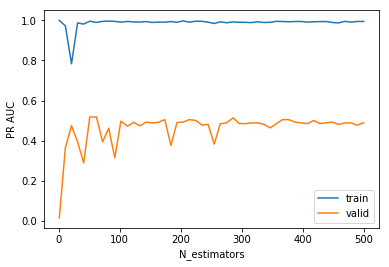

In [996]:
fig, ax = plt.subplots()
ax.plot(trees_num,pr_score_train, label='train')
ax.plot(trees_num,pr_score_val, label='valid')
ax.legend()
ax.set(xlabel='N_estimators', ylabel='PR AUC', );

We see that forest heavily overfitted. We can reduce overfitting by min_samples_leaf.

#### RF parametr min_samples_leaf

In [998]:
X_train_analize = X.drop(X[X.shop == 'Метро'].index)
X_val_analize = X[X.shop == 'Метро']
y_train_analize = X_train_analize.y
y_val_analize = X_val_analize.y
X_train_analize.drop(['shop','y'],axis=1, inplace=True)
X_val_analize.drop(['shop','y'],axis=1, inplace=True)

min_leaf_list = np.linspace(1,100, dtype=int)
pr_score_val = list()
pr_score_train = list()
for leaf_num in min_leaf_list:
    rf = RandomForestClassifier(n_estimators=500,max_features='sqrt', criterion='entropy', min_samples_leaf=leaf_num,n_jobs=-1,)
    rf.fit(X_train_analize,y_train_analize)
    _, bias, _ = ti.predict(rf,test_example) 
    bias_treshold = bias[0][1]
    preds_proba_val = rf.predict_proba(X_val_analize)
    preds_val = (preds_proba_val[:,1] > bias_treshold)
    _,_, pr_auc_val = print_scores(preds_val, y_val_analize, verbose=False);
    
    preds_proba_train = rf.predict_proba(X_train_analize)
    preds_train = (preds_proba_train[:,1] > bias_treshold)
    _,_, pr_auc_train = print_scores(preds_train, y_train_analize, verbose=False);
    
    pr_score_train.append(pr_auc_train)
    pr_score_val.append(pr_auc_val)

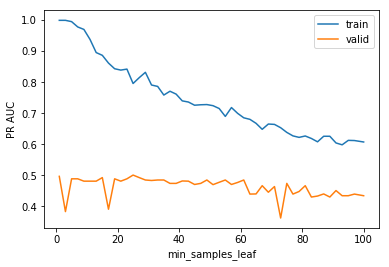

In [999]:
fig, ax = plt.subplots()
ax.plot(min_leaf_list,pr_score_train, label='train')
ax.plot(min_leaf_list,pr_score_val, label='valid')
ax.legend()
ax.set(xlabel='min_samples_leaf', ylabel='PR AUC', );

So min_samples_leaf doesn't help much.

Maybe we need more data?

In [1180]:
y_tmp = X.y
X_tmp = X.drop(['y', 'shop'], axis=1)
groups = X.shop.values

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

def plot_learning_curve(classifier = 'rf'):
    if classifier == 'rf':
        classif = RandomForestClassifier(n_estimators=100,max_features='sqrt', criterion='entropy', min_samples_leaf=25,n_jobs=-1,)
    else:
        classif = SGDClassifier(loss='log', penalty='elasticnet', max_iter=40)
    N_train, val_train, val_test = learning_curve(classif, X_tmp, y_tmp,
                                                  cv=5, groups=groups,
                                                  shuffle=True, scoring='average_precision'
                                          )
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('PR AUC')
    plt.legend()
    plt.grid(True);

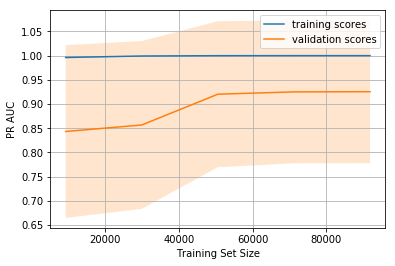

In [1181]:
plot_learning_curve(classifier='rf')

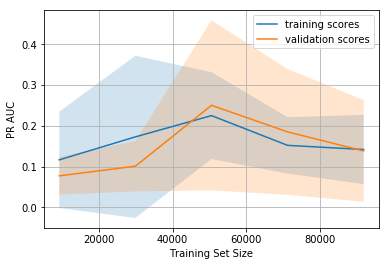

In [1182]:
plot_learning_curve(classifier='lr')

This graphs may be misleading. I can't really interpret them, the variance is too high.

There are ~100к training examples but actually, we have only 5 shops. Each of them has only 1 type of product cart. So It's <b>not</b> 100k examples it's somewhat about 5 examples. Additional data would be very very helpful.

## Part 11. Prediction for test or hold-out samples

As a test, we are going to crawl one more site - Auchan. There won't be any feature checking. We'll just check pics of product card to be sure crawler worked correctly.

In [1000]:
df_test = pd.read_csv('test_sites_markup.csv')

In [23]:
# screen for df_test[(df_test.y == 1)].screenshot
Image(url='https://habrastorage.org/webt/sv/-m/ac/sv-macheei3wqmgkpdojbuky734.png', width=900)

#### Data preparation

In [1001]:
df_test[['loc_x', 'loc_y']] = df_test['location'].str.replace("'", '"').apply(json.loads).apply(pd.Series)
df_test[['size_h', 'size_w']] = df_test['size'].str.replace("'", '"').apply(json.loads).apply(pd.Series)
df_test.size_h = df_test.size_h.astype(int)
df_test.size_w = df_test.size_w.astype(int)

In [1002]:
df_test['parent_tag'] = df_test.parent_tag.str.split('_')
df_test['childs_tags'] = df_test.childs_tags.apply(lambda x: x.replace('[', '').replace(']','').strip())

In [1003]:
df_clean_test = df_test.copy()
df_clean_test.drop(['location', 'size', 'Unnamed: 0'], axis=1, inplace=True)

In [1005]:
df_clean_test['parent_1'] = df_clean_test.parent_tag.apply(lambda x: x[-1])
df_clean_test['parent_2'] = df_clean_test.parent_tag.apply(lambda x: x[-2] if len(x) > 1 else '')
df_clean_test['parent_3'] = df_clean_test.parent_tag.apply(lambda x: x[-3] if len(x) > 2 else '')

In [1015]:
X_test = df_clean_test[features_to_train]

In [1016]:
X_test['tag'] = X_test['tag'].apply(lambda x: category_to_num[x] if x in category_to_num else -1)
X_test['parent_1'] = X_test['parent_1'].apply(lambda x: category_to_num[x] if (x) and (x in category_to_num) else -1)
X_test['parent_2'] = X_test['parent_2'].apply(lambda x: category_to_num[x] if (x) and (x in category_to_num) else -1)
X_test['parent_3'] = X_test['parent_3'].apply(lambda x: category_to_num[x] if (x) and (x in category_to_num) else -1)

#### Prediction

In [1017]:
X_train = X
y_train = X_train.y
X_train = X_train.drop(['shop', 'y'],axis=1)

y_test = X_test.y
X_test = X_test.drop(['shop', 'y'],axis=1)

test_example = X_test.head(1)
rf = RandomForestClassifier(n_estimators=400,max_features='sqrt', criterion='entropy', min_samples_leaf=25,n_jobs=-1,)
rf.fit(X_train,y_train)
_, bias, _ = ti.predict(rf,test_example) 
bias_treshold = bias[0][1]
preds_proba = rf.predict_proba(X_test)
preds = (preds_proba[:,1] > bias_treshold)
f1, roc_auc, pr_auc = print_scores(y_test, preds);

F1 score is 0.4574565416285453
ROC_AUC score is 0.9498859122792191
PR_AUC is 0.29655990510083036
confusion_matrix 
 [[10647  1186]
 [    0   500]]


In [24]:
# screen for df_test[df_test.index.isin((preds == True).index)].screenshot
Image(url='https://habrastorage.org/webt/_5/_n/uk/_5_nuk1iphmid6sfplw7hmcph1c.png', width=900)

Sweet

# Part 11. Conclusions

We tried ML on HTML markup guessing and it worked out.

On the path with our analysis, we understood ways to improve data collection. Which data features we are lacking. Which features were wrongly constructed.

At the start, we couldn't say what's more important false positive or false negative errors. After our journey, we understood that FN more critical and that we have to deal with FP. That means we'll build our data pipeline with this requirement - be stable to FP.

100k training set turned out to be only ~5-examples train set. Because of correct card almost identical in a shop and it doesn't matter if we have 10k card for a shop, it's better to have 1 card for 10k shops (but impossible).

Our metrics haven't worked out (except the confusion matrix), because our train data has examples that labeled as wrong, but in fact they identical to correct ones (div-div-ul issue). It's a good opportunity to elaborate custom loss function that penalizes softly when we are closer to our target element. Maybe it's worth to reformat problem to regression, so we would find 'distance' to the correct element.

In model selection, RF won, but it's too early to say about it because we have problems with our metrics and dataset.